In [271]:
import sys
import pandas as pd
#pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
import matplotlib.pyplot as plt
import time

In [272]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'cuda'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

No GPU detected. Ensure your setup is correct.
CatBoost can use the GPU.


In [273]:
# Declare important variables
train_path = 'train.csv'
train_2_path = 'training_extra.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'Price'
SEED = 69
skip_hypertuning = False

In [274]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [275]:
df_train_1, df_test = load_dataframes(train_path,test_path)

Loading data from D:\Users\ZCHODANIECKY\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e2 - Backpck Prices


In [276]:
df_train_2 = pd.read_csv(train_2_path)
df_train = pd.concat([df_train_1, df_train_2], ignore_index=True,axis=0)

In [277]:
df_train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [278]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [279]:
#plot_kde_grid(df_train,n_cols=4,figsize=(6,4))

In [280]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [281]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [282]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,3994318,0,3994318,0.000000,4194317.000000,2182137.162190,1178057.976858,nan,nan
1,Brand,object,126758,3.173458,5,0,3994318,nan,nan,nan,nan,Under Armour,801035
2,Material,object,110962,2.777996,4,0,3994318,nan,nan,nan,nan,Polyester,1060882
3,Size,object,87785,2.197747,3,0,3994318,nan,nan,nan,nan,Medium,1354487
4,Compartments,float64,0,0.000000,10,0,3994318,1.000000,10.000000,5.434740,2.893043,nan,nan
5,Laptop Compartment,object,98533,2.466829,2,0,3994318,nan,nan,nan,nan,Yes,1972937
6,Waterproof,object,94324,2.361454,2,0,3994318,nan,nan,nan,nan,Yes,1969205
7,Style,object,104180,2.608205,3,0,3994318,nan,nan,nan,nan,Messenger,1329677
8,Color,object,133617,3.345177,6,0,3994318,nan,nan,nan,nan,Pink,688257
9,Weight Capacity (kg),float64,1808,0.045264,1920345,0,3994318,5.000000,30.000000,18.010417,6.973969,nan,nan


<Figure size 1000x600 with 0 Axes>

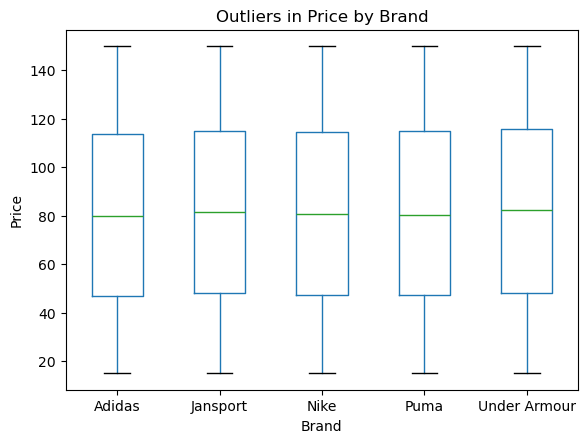

In [283]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Brand', grid=False)
plt.title(f"Outliers in {target_variable} by Brand")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Brand')
plt.show()

<Figure size 1000x600 with 0 Axes>

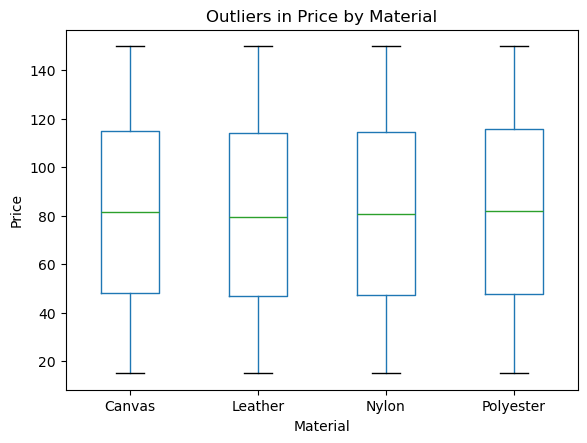

In [284]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Material', grid=False)
plt.title(f"Outliers in {target_variable} by Material")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Material')
plt.show()

<Figure size 1000x600 with 0 Axes>

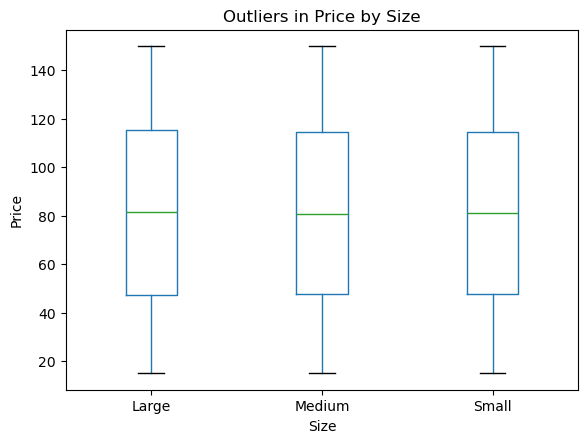

In [285]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Size', grid=False)
plt.title(f"Outliers in {target_variable} by Size")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Size')
plt.show()

<Figure size 1000x600 with 0 Axes>

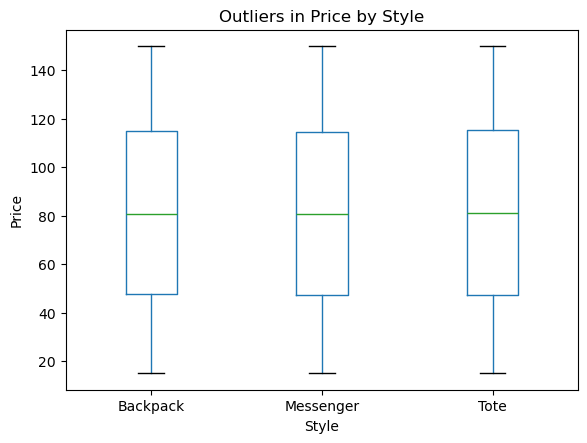

In [286]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Style', grid=False)
plt.title(f"Outliers in {target_variable} by Style")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Style')
plt.show()

<Figure size 1000x600 with 0 Axes>

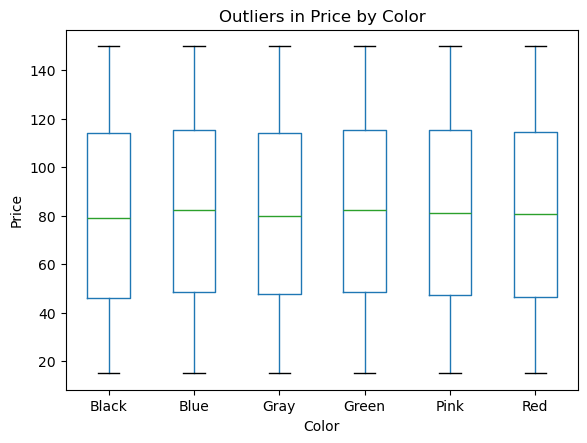

In [287]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Color', grid=False)
plt.title(f"Outliers in {target_variable} by Color")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Color')
plt.show()

In [288]:
# Log to compress outliers
# df_train['y'] = np.log(df_train[target_variable])
# df_train = df_train.drop(target_variable, axis=1)

In [289]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if target_variable in missing_numeric_columns:
        missing_numeric_columns.remove(target_variable)
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [290]:
df_train = clean_dataframe(df_train, impute_num_nulls = True, fill_cat_nulls=True)
df_test = clean_dataframe(df_test, impute_num_nulls = True, fill_cat_nulls=True)

In [291]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,3994318,0,3994318,0.000000,4194317.000000,2182137.162190,1178057.976858,nan,nan
1,Brand,object,0,0.000000,6,0,3994318,nan,nan,nan,nan,Under Armour,801035
2,Material,object,0,0.000000,5,0,3994318,nan,nan,nan,nan,Polyester,1060882
3,Size,object,0,0.000000,4,0,3994318,nan,nan,nan,nan,Medium,1354487
4,Compartments,float64,0,0.000000,10,0,3994318,1.000000,10.000000,5.434740,2.893043,nan,nan
5,Laptop Compartment,object,0,0.000000,3,0,3994318,nan,nan,nan,nan,Yes,1972937
6,Waterproof,object,0,0.000000,3,0,3994318,nan,nan,nan,nan,Yes,1969205
7,Style,object,0,0.000000,4,0,3994318,nan,nan,nan,nan,Messenger,1329677
8,Color,object,0,0.000000,7,0,3994318,nan,nan,nan,nan,Pink,688257
9,Weight Capacity (kg),float64,0,0.000000,1920345,0,3994318,5.000000,30.000000,18.010437,6.972391,nan,nan


In [292]:
df_train = df_train.rename(columns={target_variable: 'y'})

In [293]:
# Transform Dataframes
def transform_df(df):
    df = df.rename(columns={'Laptop Compartment': 'Laptop_Compartment', 'Weight Capacity (kg)': 'Weight_Capacity'})
    #df['Test_Col'] = df[['Size', 'Laptop_Compartment', 'Waterproof', 'Color']].astype(str).agg('_'.join, axis=1)
    return df

df_train = transform_df(df_train)
df_test = transform_df(df_test)


In [294]:
RMV = ['y','id']
FEATURES = [c for c in df_train.columns if not c in RMV]
combined = pd.concat([df_train,df_test],axis=0,ignore_index=True)

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")

    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)
    
df_train = combined.iloc[:len(df_train)].copy()
df_test = combined.iloc[len(df_train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )


df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)


THE 9 BASIC FEATURES ARE:
Brand (categorical) with 6 unique values
Material (categorical) with 5 unique values
Size (categorical) with 4 unique values
Compartments (numerical) with 10 unique values
Laptop_Compartment (categorical) with 3 unique values
Waterproof (categorical) with 3 unique values
Style (categorical) with 4 unique values
Color (categorical) with 7 unique values
Weight_Capacity (numerical) with 944375 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['Compartments', 'Weight_Capacity']


In [295]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,Brand,int32,0,0.000000,6,0,3994318,0.000000,5.000000,2.097417,1.477653
1,Material,int32,0,0.000000,5,0,3994318,0.000000,4.000000,1.843959,1.506528
2,Size,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.033392,0.868584
3,Compartments,float32,0,0.000000,10,0,3994318,1.000000,10.000000,5.434737,2.873955
4,Laptop_Compartment,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.530732,0.546253
5,Waterproof,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.540231,0.543701
6,Style,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.333292,1.226483
7,Color,int32,0,0.000000,7,0,3994318,0.000000,6.000000,2.678889,1.796662
8,Weight_Capacity,float32,0,0.000000,915955,0,3994318,5.000000,30.000000,18.010437,6.958634
9,y,float64,0,0.000000,48358,0,3994318,15.000000,150.000000,81.362175,38.938684


In [296]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_histograms(df, bins=20):
    """
    Plots histograms for all numerical features in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    bins (int): Number of bins for histograms (default: 20)
    """
    numerical_features = df.select_dtypes(include=[np.number]).columns  # Select numerical columns
    num_features = len(numerical_features)
    
    if num_features == 0:
        print("No numerical features found.")
        return
    
    cols = 4  # Number of histograms per row
    rows = (num_features // cols) + (num_features % cols > 0)  # Compute number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
    axes = axes.flatten()  # Flatten for easy iteration
    
    for i, feature in enumerate(numerical_features):
        axes[i].hist(df[feature].dropna(), bins=bins, edgecolor='black', alpha=0.7)
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
    
    # Hide unused subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

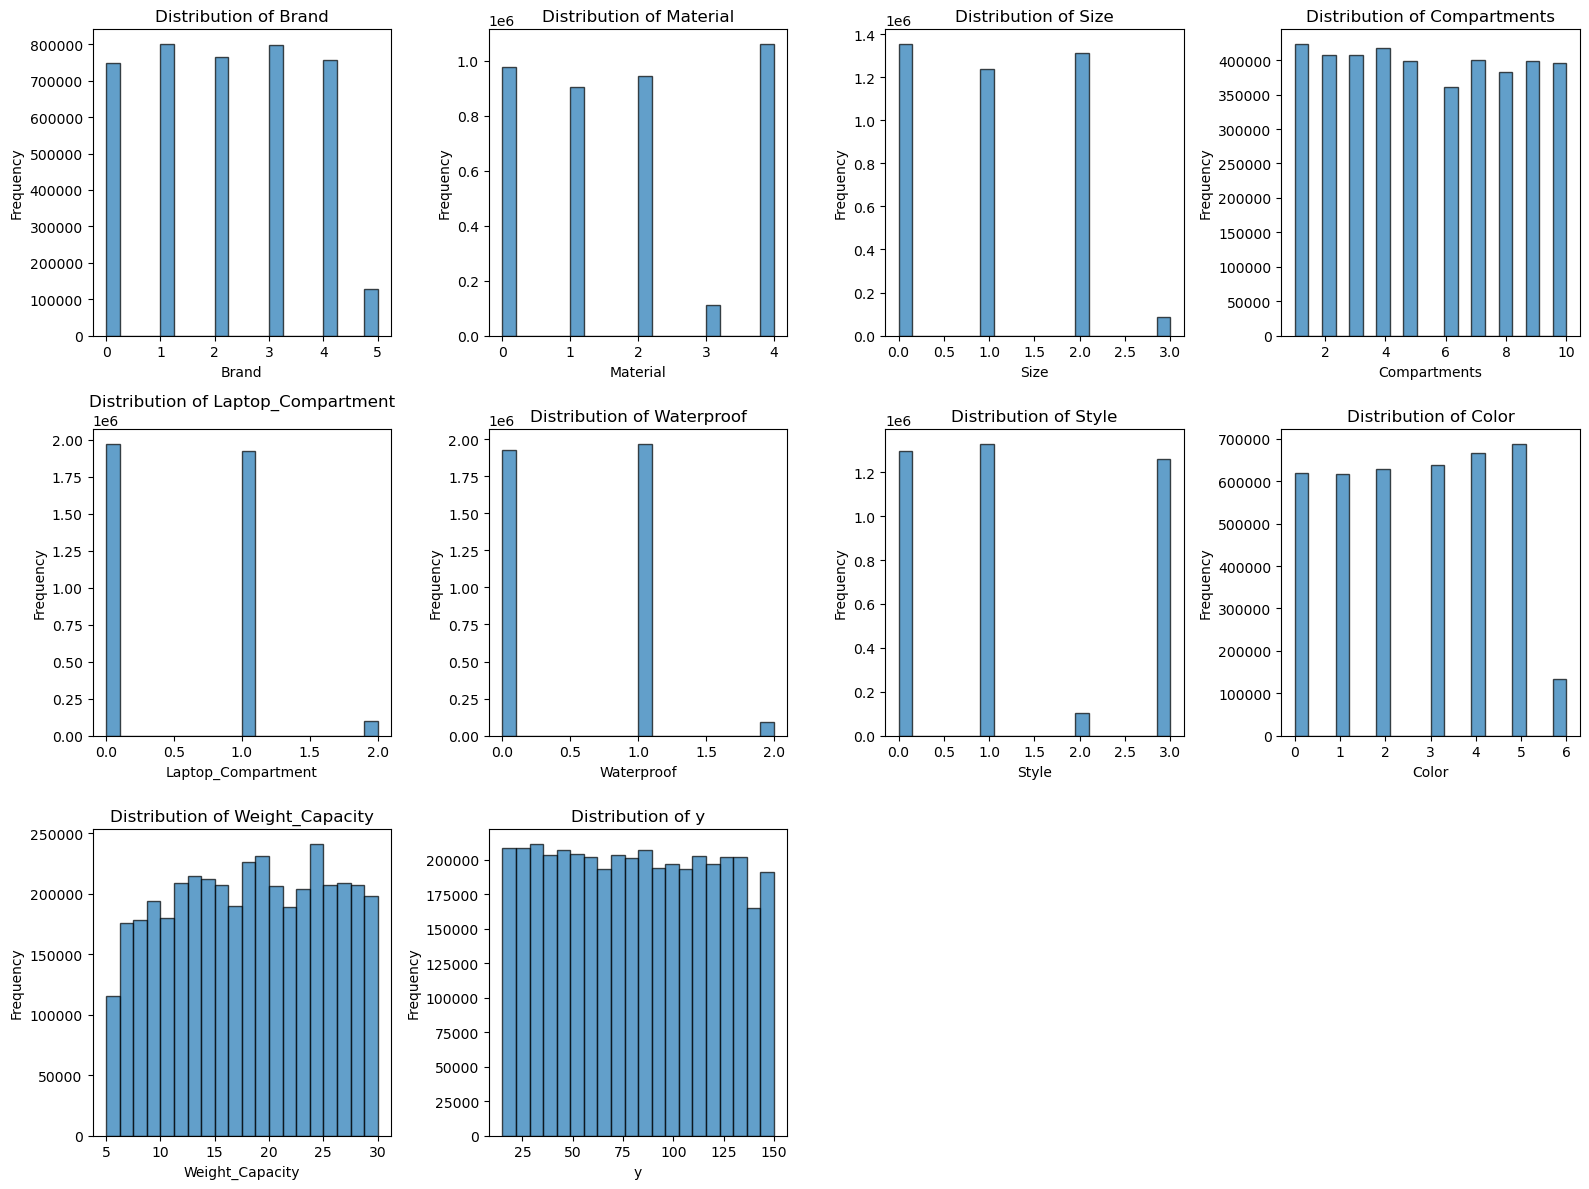

In [297]:
plot_feature_histograms(df_train)

In [298]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,Brand,int32,0,0.000000,6,0,3994318,0.000000,5.000000,2.097417,1.477653
1,Material,int32,0,0.000000,5,0,3994318,0.000000,4.000000,1.843959,1.506528
2,Size,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.033392,0.868584
3,Compartments,float32,0,0.000000,10,0,3994318,1.000000,10.000000,5.434737,2.873955
4,Laptop_Compartment,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.530732,0.546253
5,Waterproof,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.540231,0.543701
6,Style,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.333292,1.226483
7,Color,int32,0,0.000000,7,0,3994318,0.000000,6.000000,2.678889,1.796662
8,Weight_Capacity,float32,0,0.000000,915955,0,3994318,5.000000,30.000000,18.010437,6.958634
9,y,float64,0,0.000000,48358,0,3994318,15.000000,150.000000,81.362175,38.938684


In [299]:
# lists2 = [['Material','Size','Color']]
# print(f"We have {len(lists2)} powerful combination of columns!")
# print(lists2)
lists2 = []

In [300]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

x_train = df_train.drop('y', axis=1)
y_train = df_train['y'].copy()


In [301]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

best_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}

# Initialize the XGBRegressor
model = XGBRegressor(
    **best_params,
    #device=device,
    random_state=SEED,     
    objective='reg:squarederror'
)

# Perform cross-validation with RMSE
scores = cross_val_score(model, x_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
model_score = np.mean(scores)  # RMSE is negative, so higher is worse
print(-model_score)

38.885310558556455


In [302]:
# 38.885310558556455

In [303]:
from itertools import combinations
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

def forward_feature_selection(X, y, model, max_comb=6, scoring='neg_root_mean_squared_error', cv=3):
    selected_features = []  # Store best feature combinations
    best_score = np.inf  # RMSE is minimized, so initialize with a high value
    best_features = None  # Track best feature set

    feature_list = ['Brand','Material','Size','Laptop Compartment','Waterproof', 'Style', 'Color']

    # Iterate over different combination sizes (2,3,4,...,max_comb)
    for comb_size in range(2, max_comb + 1):
        print(f"Trying {comb_size}-feature combinations...")
        best_local_score = -10000000
        best_local_feature = None

        # Try all combinations of 'comb_size' features
        for combo in combinations(feature_list, comb_size):
            # Create a new categorical feature by concatenation
            X_new = X.copy()
            new_feature_name = f"CE_{'_'.join(combo)}"
            X_new[new_feature_name] = X[list(combo)].astype(str).agg('_'.join, axis=1)
            
             # Convert categorical feature into numerical using factorize()
            X_new[new_feature_name], _ = X_new[new_feature_name].factorize()
            X_new[new_feature_name] -= X_new[new_feature_name].min()

            # Perform cross-validation with RMSE
            scores = cross_val_score(model, X_new, y, cv=cv, scoring=scoring)
            mean_score = np.mean(scores)  # RMSE is negative, so higher is worse
            
            print(f'{combo} : {mean_score}')         
            # If the new feature reduces RMSE (improves the model), keep it
            if mean_score > best_local_score:
                best_local_score = mean_score
                best_local_feature_set = combo

        # If an improvement was found, save the best feature of this round
        if best_local_feature_set:
            best_score = best_local_score
            best_features = best_local_feature_set
            print(f"New Best Feature Set: {best_features}, New Best RMSE: {-best_score:.4f}")

    return best_features, -best_score  # Return the best feature set and positive RMSE


In [307]:
from xgboost import XGBRegressor
import time

best_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}

# Initialize the XGBRegressor
model = XGBRegressor(
    **best_params,
    random_state=SEED,
    #device=device,
    objective='reg:squarederror'
)

start = time.time()
# Run Forward Feature Selection with RMSE
best_features, best_rmse = forward_feature_selection(x_train, y_train, model, max_comb=4, scoring='neg_root_mean_squared_error', cv=5)

end = time.time()
elapsed = end-start
print(f"Feature Selection took {elapsed:.1f} seconds")

# Print results
print("Best Feature Combinations:", best_features)
print("Best RMSE Score:", best_rmse)

Trying 2-feature combinations...
('Brand', 'Material') : -38.884699737636524


KeyboardInterrupt: 

In [305]:
# Trying 2-feature combinations...
# ('Brand', 'Material') : -38.9302699102424
# ('Brand', 'Size') : -38.93063754845522
# ('Brand', 'Laptop Compartment') : -38.935012464231136
# ('Brand', 'Waterproof') : -38.93313007401145
# ('Brand', 'Style') : -38.93470674500861
# ('Brand', 'Color') : -38.92986548339745
# ('Material', 'Size') : -38.93080632244352
# ('Material', 'Laptop Compartment') : -38.93362993165491
# ('Material', 'Waterproof') : -38.93171818358589
# ('Material', 'Style') : -38.93358118743051
# ('Material', 'Color') : -38.928640034206026
# ('Size', 'Laptop Compartment') : -38.93533356550596
# ('Size', 'Waterproof') : -38.932900045096915
# ('Size', 'Style') : -38.93588049999621
# ('Size', 'Color') : -38.93059769700584
# ('Laptop Compartment', 'Waterproof') : -38.93534492795162
# ('Laptop Compartment', 'Style') : -38.938074302208726
# ('Laptop Compartment', 'Color') : -38.93312488761227
# ('Waterproof', 'Style') : -38.93584104976536
# ('Waterproof', 'Color') : -38.931079089557706
# ('Style', 'Color') : -38.93309674013352
# New Best Feature Set: ('Laptop Compartment', 'Style'), New Best RMSE: 38.9381
# Trying 3-feature combinations...
# ('Brand', 'Material', 'Size') : -38.92592349619997
# ('Brand', 'Material', 'Laptop Compartment') : -38.930395926843794
# ('Brand', 'Material', 'Waterproof') : -38.92853835416274
# ('Brand', 'Material', 'Style') : -38.93050598879546
# ('Brand', 'Material', 'Color') : -38.926076318587256
# ('Brand', 'Size', 'Laptop Compartment') : -38.9301924266554
# ('Brand', 'Size', 'Waterproof') : -38.92749355129526
# ('Brand', 'Size', 'Style') : -38.93078971635316
# ('Brand', 'Size', 'Color') : -38.92701438939042
# ('Brand', 'Laptop Compartment', 'Waterproof') : -38.93180992870275
# ('Brand', 'Laptop Compartment', 'Style') : -38.93463967736109
# ('Brand', 'Laptop Compartment', 'Color') : -38.930259710455424
# ('Brand', 'Waterproof', 'Style') : -38.93251044579712
# ('Brand', 'Waterproof', 'Color') : -38.928488095726856
# ('Brand', 'Style', 'Color') : -38.93061086545008
# ('Material', 'Size', 'Laptop Compartment') : -38.92998481676937
# ('Material', 'Size', 'Waterproof') : -38.92761837776242
# ('Material', 'Size', 'Style') : -38.93092868674755
# ('Material', 'Size', 'Color') : -38.92636915005986
# ('Material', 'Laptop Compartment', 'Waterproof') : -38.93030597437149
# ('Material', 'Laptop Compartment', 'Style') : -38.93313457454553
# ('Material', 'Laptop Compartment', 'Color') : -38.92884148895854
# ('Material', 'Waterproof', 'Style') : -38.93107921137687
# ('Material', 'Waterproof', 'Color') : -38.92675316511963
# ('Material', 'Style', 'Color') : -38.92920773792099
# ('Size', 'Laptop Compartment', 'Waterproof') : -38.93089620094994
# ('Size', 'Laptop Compartment', 'Style') : -38.93511272190775
# ('Size', 'Laptop Compartment', 'Color') : -38.93016917119858
# ('Size', 'Waterproof', 'Style') : -38.93216561329706
# ('Size', 'Waterproof', 'Color') : -38.92771349756689
# ('Size', 'Style', 'Color') : -38.93137742652178
# ('Laptop Compartment', 'Waterproof', 'Style') : -38.93447105651601
# ('Laptop Compartment', 'Waterproof', 'Color') : -38.930087401292305
# ('Laptop Compartment', 'Style', 'Color') : -38.93307094906139
# ('Waterproof', 'Style', 'Color') : -38.93062144443654
# New Best Feature Set: ('Size', 'Laptop Compartment', 'Style'), New Best RMSE: 38.9351
# Trying 4-feature combinations...
# ('Brand', 'Material', 'Size', 'Laptop Compartment') : -38.930515604363734
# ('Brand', 'Material', 'Size', 'Waterproof') : -38.929617626120574
# ('Brand', 'Material', 'Size', 'Style') : -38.93165113237366
# ('Brand', 'Material', 'Size', 'Color') : -38.9319109470507
# ('Brand', 'Material', 'Laptop Compartment', 'Waterproof') : -38.93051196634291
# ('Brand', 'Material', 'Laptop Compartment', 'Style') : -38.932094598765836
# ('Brand', 'Material', 'Laptop Compartment', 'Color') : -38.92990618593194
# ('Brand', 'Material', 'Waterproof', 'Style') : -38.93142416949206
# ('Brand', 'Material', 'Waterproof', 'Color') : -38.929731387320075
# ('Brand', 'Material', 'Style', 'Color') : -38.93307931552696
# ('Brand', 'Size', 'Laptop Compartment', 'Waterproof') : -38.92680580850123
# ('Brand', 'Size', 'Laptop Compartment', 'Style') : -38.93396801724744
# ('Brand', 'Size', 'Laptop Compartment', 'Color') : -38.9314278133556
# ('Brand', 'Size', 'Waterproof', 'Style') : -38.933631027585854
# ('Brand', 'Size', 'Waterproof', 'Color') : -38.929635153977415
# ('Brand', 'Size', 'Style', 'Color') : -38.933241629790686
# ('Brand', 'Laptop Compartment', 'Waterproof', 'Style') : -38.93180946143022
# ('Brand', 'Laptop Compartment', 'Waterproof', 'Color') : -38.93032288741696
# ('Brand', 'Laptop Compartment', 'Style', 'Color') : -38.9327908362113
# ('Brand', 'Waterproof', 'Style', 'Color') : -38.9314385378657
# ('Material', 'Size', 'Laptop Compartment', 'Waterproof') : -38.92650310928074
# ('Material', 'Size', 'Laptop Compartment', 'Style') : -38.93125545882827
# ('Material', 'Size', 'Laptop Compartment', 'Color') : -38.9297830589786
# ('Material', 'Size', 'Waterproof', 'Style') : -38.92833948098533
# ('Material', 'Size', 'Waterproof', 'Color') : -38.928523885210105
# ('Material', 'Size', 'Style', 'Color') : -38.931467253506966
# ('Material', 'Laptop Compartment', 'Waterproof', 'Style') : -38.9301205504411
# ('Material', 'Laptop Compartment', 'Waterproof', 'Color') : -38.92883492033138
# ('Material', 'Laptop Compartment', 'Style', 'Color') : -38.93102840998662
# ('Material', 'Waterproof', 'Style', 'Color') : -38.93147602318284
# ('Size', 'Laptop Compartment', 'Waterproof', 'Style') : -38.930550006283944
# ('Size', 'Laptop Compartment', 'Waterproof', 'Color') : -38.92662190521558
# ('Size', 'Laptop Compartment', 'Style', 'Color') : -38.93345959270185
# ('Size', 'Waterproof', 'Style', 'Color') : -38.93216428759725
# ('Laptop Compartment', 'Waterproof', 'Style', 'Color') : -38.930513035163656
# New Best Feature Set: ('Brand', 'Size', 'Laptop Compartment', 'Style'), New Best RMSE: 38.9340
# Feature Selection took 27482.6 seconds
# Best Feature Combinations: ('Brand', 'Size', 'Laptop Compartment', 'Style')
# Best RMSE Score: 38.93396801724744

In [306]:
m = np.sqrt(np.mean( (df_train.y.values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")

NameError: name 'oof' is not defined

In [ ]:
# Overall CV RMSLE = 38.68810

In [ ]:
from xgboost import plot_importance

#Plot feature importance
plot_importance(model, importance_type='gain', max_num_features=25)  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()